My idea is breaking each strong node to multiple nodes!

source: https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX

# hide

In [558]:
import warnings
warnings.filterwarnings("ignore")

In [559]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [560]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.1+cu113


## Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [561]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [562]:
log = {}

#Test

In [563]:
log['dataset']=dataset

In [564]:
nodes = np.zeros(2708)

In [565]:
for i in range(10556):
    a =  data.edge_index[0][i]
    b =  data.edge_index[1][i]
    nodes[a]+=1
    nodes[b]+=1

In [566]:
max(nodes)

336.0

In [567]:
original_nodes = np.copy(nodes)

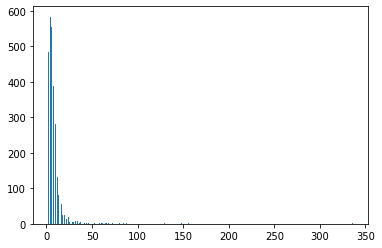

In [568]:
_ = plt.hist(nodes, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [569]:
nodes2 = nodes[nodes>50]
len(nodes2)

17

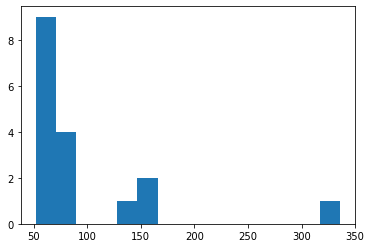

In [570]:
_ = plt.hist(nodes2, bins='auto')  # arguments are passed to np.histogram
plt.show()

I guess break each extra 100 to a new part

In [571]:
data = dataset[0]

In [572]:
log['raw data'] = str(data)

In [573]:
x = data.x
ei = data.edge_index 
y = data.y
train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

In [574]:
def multiappender(l,e):
    d = e.reshape(1,-1)
    l = torch.cat([l, torch.tensor(d)], dim=0)
    return l

In [575]:
def appender(l,e):
    z = torch.cat([l, torch.tensor(e).reshape(1)], dim=0)
    return z

In [576]:
log['info'] = {}
log['info']['#of(edge_index,x,ei,train_mask']=[len(data.edge_index[0]),len(data.x),len(ei),len(train_mask)]

## run phase 1

save original data:

In [577]:
def make_data_ready(flag_type_2,
                    each_part_size,
                    istype2 = False):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
    data = dataset[0]
    
    redunclass = [[i] for i in range(len(data.x))]

    nodes = np.zeros(len(data.x))
    for i in range(len(data.edge_index[0])):
        a =  data.edge_index[0][i]
        b =  data.edge_index[1][i]
        nodes[a]+=1
        nodes[b]+=1

    strongs = []
    for i in tqdm(range(len(nodes))):
        if nodes[i]>each_part_size:
            strongs.append(i)

    x = data.x
    ei = data.edge_index 
    y = data.y
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
    
    d = False  

    for s in tqdm(strongs):
        n = nodes[s]
        while(n>each_part_size):

            x = multiappender(x,x[s])
            redunclass[s].append(len(x)-1)
            y = appender(y,y[s])

            train_mask = appender(train_mask,train_mask[s])
            val_mask = appender(val_mask,val_mask[s]) 
            
            if istype2:
                test_mask = appender(test_mask,False)
                test_mask[s] = False
            else:
                test_mask = appender(test_mask,test_mask[s])
            
            if n >= each_part_size*1.5:
                t = each_part_size
                n-=t
                
                for i in range(len(ei[0])):
                    e1,e2 = ei[0][i],ei[1][i]
                    
                    if t<=0:
                        break

                    if e1==s:
                        t-=1
                        ei[0][i] = len(val_mask)-1
                    elif e2==s:
                        t-=1
                        ei[1][i] = len(val_mask)-1
                    
            else:
                t = int((n+1)/2)
                n-=t
                
                for i in range(len(ei[0])):
                    if t<=0:
                        break

                    e1,e2 = ei[0][i],ei[1][i]
                    if e1==s:
                        t-=1
                        ei[0][i] = len(val_mask)-1
                    elif e2==s:
                        t-=1
                        ei[1][i] = len(val_mask)-1
                    
            if flag_type_2:

                print(len(data.edge_index[0]),len(data.x),len(ei))

                d = torch.tensor([len(val_mask)-1,s])
                d = d.reshape(2,-1)
                ei = torch.cat([ei, torch.tensor(d)], dim=-1)

                d = torch.tensor([s,len(val_mask)-1])
                d = d.reshape(2,-1)
                ei = torch.cat([ei, torch.tensor(d)], dim=-1)
    data.x = x
    data.edge_index = ei 
    data.y = y
    data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

    nodes = np.zeros(len(data.x))
    for i in range(len(data.edge_index[0])):
        a =  data.edge_index[0][i]
        b =  data.edge_index[1][i]
        nodes[a]+=1
        nodes[b]+=1

    return x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass

In [578]:
x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = True,
                                                                                       each_part_size = 100,
                                                                                       istype2 = False)

  0%|          | 0/4 [00:00<?, ?it/s]

10556 2708 2
10556 2708 2


 50%|█████     | 2/4 [00:00<00:00,  4.93it/s]

10556 2708 2
10556 2708 2


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

10556 2708 2
10556 2708 2


In [579]:
sum(train_mask),sum(val_mask),sum(test_mask)

(tensor(140), tensor(501), tensor(1001))

In [580]:
max(nodes)

102.0

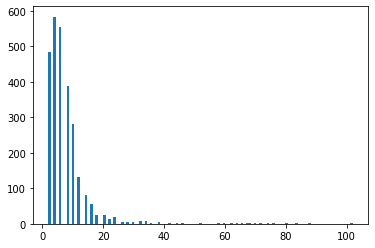

In [581]:
_ = plt.hist(nodes, bins='auto')  # arguments are passed to np.histogram
plt.show()

Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

# models running:

In [754]:
log

{'dataset': Cora(),
 'raw data': 'Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])',
 'info': {'#of(edge_index,x,ei,train_mask': [10556, 2708, 2, 2708]},
 'test4': {'each_part_size': 10,
  'flag type 2': False,
  'mlp': {'acc1': '0.5347', 'acc2': '0.5798', 'acc3': '0.5798'},
  'gnn1': {'acc1': '0.7822', 'acc2': '0.7840', 'acc3': '0.7843'},
  'gnn2': {'acc1': '0.7797', 'acc2': '0.7795', 'acc3': '0.7781'},
  'semi gnn': {'acc1': '0.7797', 'acc2': '0.7866', 'acc3': '0.7858'}},
 'test5': {'each_part_size': 20,
  'flag type 2': False,
  'mlp': {'acc1': '0.5494', 'acc2': '0.5886', 'acc3': '0.5886'},
  'gnn1': {'acc1': '0.7872', 'acc2': '0.7925', 'acc3': '0.7925'},
  'gnn2': {'acc1': '0.7689', 'acc2': '0.7832', 'acc3': '0.7829'},
  'semi gnn': {'acc1': '0.8015', 'acc2': '0.8072', 'acc3': '0.8065'}},
 'test6': {'each_part_size': 50,
  'flag type 2': False,
  'mlp': {'acc1': '0.5666', 'acc2': '0.6004', 'acc3': '0.6004'},
  'gnn1': {'acc

In [583]:
# log = {}
# index = 0

In [584]:
# index = 0
# del log['test1']
# log

In [738]:
each_part_size = 10
flag_type_2 = True
istype2 = False

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [739]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = flag_type_2,
                                                                                       each_part_size = each_part_size,
                                                                                       istype2 = istype2) #flag_type_2 is connecting breaked nodes and istype2 means avoid breaked nodes in test 

<IPython.core.display.Javascript object>

  1%|          | 4/417 [00:00<00:18, 22.65it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  2%|▏         | 10/417 [00:00<00:14, 27.85it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  3%|▎         | 14/417 [00:00<00:13, 29.24it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  5%|▍         | 20/417 [00:01<00:25, 15.51it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  6%|▌         | 23/417 [00:01<00:33, 11.71it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  6%|▌         | 25/417 [00:01<00:42,  9.24it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  6%|▋         | 27/417 [00:02<00:40,  9.69it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


  8%|▊         | 35/417 [00:02<00:24, 15.83it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 11%|█         | 44/417 [00:02<00:15, 24.84it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 12%|█▏        | 48/417 [00:03<00:22, 16.44it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 

 12%|█▏        | 51/417 [00:03<00:20, 17.65it/s]

2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 13%|█▎        | 54/417 [00:04<00:45,  7.96it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 13%|█▎        | 56/417 [00:04<00:45,  7.85it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 14%|█▍        | 58/417 [00:04<00:45,  7.91it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708

 16%|█▌        | 65/417 [00:04<00:26, 13.40it/s]

 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 16%|█▋        | 68/417 [00:04<00:22, 15.74it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 17%|█▋        | 71/417 [00:05<00:33, 10.39it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 18%|█▊        | 75/417 [00:05<00:30, 11.07it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 19%|█▊        | 78/417 [00:06<00:28, 11.73it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 20%|██        | 84/417 [00:06<00:20, 16.11it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 21%|██        | 86/417 [00:06<00:22, 14.81it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 21%|██▏       | 89/417 [00:06<00:22, 14.47it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 22%|██▏       | 91/417 [00:06<00:26, 12.30it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 23%|██▎       | 95/417 [00:07<00:24, 13.22it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 23%|██▎       | 97/417 [00:07<00:24, 13.30it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 24%|██▍       | 101/417 [00:07<00:22, 14.27it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 25%|██▍       | 103/417 [00:08<00:36,  8.55it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 26%|██▌       | 107/417 [00:08<00:26, 11.84it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 27%|██▋       | 111/417 [00:08<00:21, 14.45it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 27%|██▋       | 113/417 [00:08<00:24, 12.27it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 28%|██▊       | 115/417 [00:08<00:26, 11.50it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 28%|██▊       | 117/417 [00:09<00:35,  8.40it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 29%|██▉       | 121/417 [00:09<00:26, 11.32it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 29%|██▉       | 123/417 [00:10<00:40,  7.18it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 30%|███       | 127/417 [00:10<00:29,  9.87it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 31%|███       | 129/417 [00:10<00:25, 11.13it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 32%|███▏      | 133/417 [00:10<00:26, 10.55it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 32%|███▏      | 135/417 [00:11<00:25, 10.96it/s]

10556 2708 2
10556 2708 2


 33%|███▎      | 137/417 [00:11<00:25, 11.07it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708

 34%|███▍      | 141/417 [00:11<00:21, 12.58it/s]

 2
10556 2708 2
10556 2708 2
10556 2708 2


 35%|███▍      | 145/417 [00:11<00:20, 13.52it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 35%|███▌      | 147/417 [00:11<00:19, 13.60it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 36%|███▌      | 151/417 [00:12<00:19, 13.61it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 37%|███▋      | 153/417 [00:12<00:20, 13.12it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 37%|███▋      | 155/417 [00:12<00:26,  9.91it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 38%|███▊      | 159/417 [00:13<00:27,  9.44it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 39%|███▊      | 161/417 [00:13<00:25, 10.24it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 40%|███▉      | 165/417 [00:14<00:36,  6.90it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 40%|████      | 167/417 [00:14<00:42,  5.89it/s]

10556 2708 2
10556 2708 2


 41%|████      | 169/417 [00:14<00:35,  6.93it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 41%|████▏     | 173/417 [00:15<00:27,  8.87it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 42%|████▏     | 175/417 [00:15<00:37,  6.39it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 42%|████▏     | 177/417 [00:15<00:32,  7.42it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 43%|████▎     | 179/417 [00:16<00:28,  8.41it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 43%|████▎     | 181/417 [00:16<00:32,  7.37it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 44%|████▎     | 182/417 [00:16<00:35,  6.68it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 45%|████▍     | 186/417 [00:17<00:34,  6.75it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 45%|████▌     | 188/417 [00:17<00:32,  7.01it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 46%|████▌     | 190/417 [00:17<00:28,  8.04it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 46%|████▋     | 193/417 [00:18<00:31,  7.17it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 47%|████▋     | 195/417 [00:18<00:27,  8.17it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 47%|████▋     | 197/417 [00:18<00:24,  8.92it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556

 48%|████▊     | 199/417 [00:19<00:37,  5.77it/s]

 2708 2
10556 2708 2


 48%|████▊     | 200/417 [00:19<00:37,  5.72it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 48%|████▊     | 202/417 [00:19<00:31,  6.79it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 49%|████▉     | 204/417 [00:20<00:39,  5.46it/s]

10556 2708 2
10556 2708 2


 49%|████▉     | 206/417 [00:20<00:34,  6.06it/s]

10556 2708 2
10556 2708 2


 50%|████▉     | 208/417 [00:20<00:28,  7.29it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 50%|█████     | 210/417 [00:20<00:25,  8.20it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 51%|█████     | 212/417 [00:21<00:35,  5.74it/s]

10556 2708 2
10556 2708 2


 52%|█████▏    | 215/417 [00:21<00:30,  6.60it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 52%|█████▏    | 216/417 [00:21<00:28,  7.08it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 53%|█████▎    | 219/417 [00:25<01:51,  1.78it/s]

10556 2708 2
10556 2708 2


 53%|█████▎    | 221/417 [00:25<01:16,  2.57it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 54%|█████▎    | 224/417 [00:25<00:45,  4.25it/s]

10556 2708 2
10556 2708 2
10556 2708 2


 54%|█████▍    | 225/417 [00:25<00:47,  4.02it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 54%|█████▍    | 227/417 [00:26<00:42,  4.46it/s]

10556 2708 2
10556 2708 2


 55%|█████▍    | 229/417 [00:26<00:31,  6.00it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 55%|█████▌    | 231/417 [00:27<00:37,  4.93it/s]

10556 2708 2
10556 2708 2


 56%|█████▌    | 233/417 [00:27<00:28,  6.47it/s]

10556 2708 2
10556 2708 2


 56%|█████▋    | 235/417 [00:27<00:23,  7.66it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 57%|█████▋    | 237/417 [00:28<00:33,  5.42it/s]

10556 2708 2
10556 2708 2


 57%|█████▋    | 238/417 [00:28<00:34,  5.16it/s]

10556 2708 2
10556 2708 2


 58%|█████▊    | 240/417 [00:28<00:26,  6.63it/s]

10556 2708 2
10556 2708 2


 58%|█████▊    | 242/417 [00:28<00:23,  7.47it/s]

10556 2708 2
10556 2708 2


 59%|█████▊    | 244/417 [00:28<00:22,  7.60it/s]

10556 2708 2
10556 2708 2


 59%|█████▉    | 245/417 [00:29<00:22,  7.78it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 59%|█████▉    | 247/417 [00:29<00:35,  4.82it/s]

10556 2708 2
10556 2708 2


 60%|█████▉    | 249/417 [00:29<00:28,  5.96it/s]

10556 2708 2
10556 2708 2


 60%|██████    | 251/417 [00:30<00:23,  7.05it/s]

10556 2708 2
10556 2708 2


 61%|██████    | 253/417 [00:30<00:23,  7.02it/s]

10556 2708 2
10556 2708 2


 61%|██████    | 255/417 [00:30<00:21,  7.51it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 61%|██████▏   | 256/417 [00:31<00:56,  2.87it/s]

10556 2708 2
10556 2708 2


 62%|██████▏   | 257/417 [00:31<00:56,  2.84it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 62%|██████▏   | 259/417 [00:32<00:44,  3.53it/s]

10556 2708 2
10556 2708 2


 62%|██████▏   | 260/417 [00:32<00:42,  3.71it/s]

10556 2708 2
10556 2708 2


 63%|██████▎   | 262/417 [00:32<00:31,  4.95it/s]

10556 2708 2
10556 2708 2


 63%|██████▎   | 264/417 [00:33<00:24,  6.13it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 64%|██████▎   | 265/417 [00:33<00:33,  4.49it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 64%|██████▍   | 267/417 [00:35<01:11,  2.11it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 65%|██████▍   | 269/417 [00:35<00:52,  2.83it/s]

10556 2708 2
10556 2708 2


 65%|██████▍   | 271/417 [00:36<00:35,  4.17it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 65%|██████▌   | 273/417 [00:36<00:34,  4.22it/s]

10556 2708 2
10556 2708 2


 66%|██████▌   | 275/417 [00:36<00:25,  5.49it/s]

10556 2708 2
10556 2708 2


 66%|██████▌   | 276/417 [00:37<00:29,  4.82it/s]

10556 2708 2
10556 2708 2


 66%|██████▋   | 277/417 [00:37<00:30,  4.52it/s]

10556 2708 2
10556 2708 2


 67%|██████▋   | 279/417 [00:37<00:24,  5.69it/s]

10556 2708 2
10556 2708 2


 67%|██████▋   | 281/417 [00:37<00:21,  6.39it/s]

10556 2708 2
10556 2708 2


 68%|██████▊   | 283/417 [00:38<00:19,  6.92it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 68%|██████▊   | 285/417 [00:38<00:24,  5.35it/s]

10556 2708 2
10556 2708 2


 69%|██████▊   | 286/417 [00:38<00:22,  5.78it/s]

10556 2708 2
10556 2708 2


 69%|██████▉   | 288/417 [00:39<00:23,  5.51it/s]

10556 2708 2
10556 2708 2


 70%|██████▉   | 290/417 [00:39<00:19,  6.44it/s]

10556 2708 2
10556 2708 2


 70%|███████   | 292/417 [00:39<00:18,  6.85it/s]

10556 2708 2
10556 2708 2


 70%|███████   | 293/417 [00:39<00:17,  6.98it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 71%|███████   | 294/417 [00:40<00:46,  2.66it/s]

10556 2708 2
10556 2708 2


 71%|███████   | 296/417 [00:41<00:31,  3.90it/s]

10556 2708 2
10556 2708 2


 71%|███████▏  | 298/417 [00:41<00:23,  5.11it/s]

10556 2708 2
10556 2708 2


 72%|███████▏  | 300/417 [00:41<00:19,  5.97it/s]

10556 2708 2
10556 2708 2


 72%|███████▏  | 302/417 [00:41<00:18,  6.21it/s]

10556 2708 2
10556 2708 2


 73%|███████▎  | 304/417 [00:42<00:17,  6.45it/s]

10556 2708 2
10556 2708 2


 73%|███████▎  | 305/417 [00:42<00:16,  6.63it/s]

10556 2708 2
10556 2708 2


 74%|███████▎  | 307/417 [00:42<00:18,  5.90it/s]

10556 2708 2
10556 2708 2


 74%|███████▍  | 309/417 [00:43<00:17,  6.31it/s]

10556 2708 2
10556 2708 2


 75%|███████▍  | 311/417 [00:43<00:15,  6.91it/s]

10556 2708 2
10556 2708 2


 75%|███████▌  | 313/417 [00:43<00:15,  6.89it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 75%|███████▌  | 314/417 [00:44<00:34,  3.00it/s]

10556 2708 2
10556 2708 2


 76%|███████▌  | 316/417 [00:44<00:23,  4.21it/s]

10556 2708 2
10556 2708 2


 76%|███████▌  | 317/417 [00:44<00:21,  4.63it/s]

10556 2708 2
10556 2708 2


 76%|███████▋  | 319/417 [00:45<00:20,  4.79it/s]

10556 2708 2
10556 2708 2


 77%|███████▋  | 320/417 [00:45<00:18,  5.23it/s]

10556 2708 2
10556 2708 2


 77%|███████▋  | 322/417 [00:45<00:18,  5.24it/s]

10556 2708 2
10556 2708 2


 78%|███████▊  | 324/417 [00:46<00:15,  5.86it/s]

10556 2708 2
10556 2708 2


 78%|███████▊  | 326/417 [00:46<00:14,  6.21it/s]

10556 2708 2
10556 2708 2


 78%|███████▊  | 327/417 [00:46<00:17,  5.17it/s]

10556 2708 2
10556 2708 2


 79%|███████▊  | 328/417 [00:46<00:18,  4.73it/s]

10556 2708 2
10556 2708 2


 79%|███████▉  | 329/417 [00:47<00:17,  5.07it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 79%|███████▉  | 331/417 [00:48<00:38,  2.21it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 80%|███████▉  | 333/417 [00:49<00:30,  2.73it/s]

10556 2708 2
10556 2708 2


 80%|████████  | 334/417 [00:49<00:25,  3.30it/s]

10556 2708 2
10556 2708 2


 80%|████████  | 335/417 [00:49<00:24,  3.29it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 81%|████████  | 336/417 [00:50<00:39,  2.04it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 81%|████████  | 337/417 [00:51<00:45,  1.75it/s]

10556 2708 2
10556 2708 2


 81%|████████▏ | 339/417 [00:51<00:27,  2.79it/s]

10556 2708 2
10556 2708 2


 82%|████████▏ | 341/417 [00:52<00:19,  3.80it/s]

10556 2708 2
10556 2708 2


 82%|████████▏ | 343/417 [00:52<00:15,  4.83it/s]

10556 2708 2
10556 2708 2


 83%|████████▎ | 345/417 [00:52<00:12,  5.70it/s]

10556 2708 2
10556 2708 2


 83%|████████▎ | 347/417 [00:53<00:11,  6.04it/s]

10556 2708 2
10556 2708 2


 84%|████████▎ | 349/417 [00:53<00:11,  6.18it/s]

10556 2708 2
10556 2708 2


 84%|████████▍ | 351/417 [00:53<00:10,  6.20it/s]

10556 2708 2
10556 2708 2


 85%|████████▍ | 353/417 [00:54<00:10,  6.12it/s]

10556 2708 2
10556 2708 2


 85%|████████▌ | 355/417 [00:54<00:10,  6.16it/s]

10556 2708 2
10556 2708 2


 85%|████████▌ | 356/417 [00:54<00:12,  4.76it/s]

10556 2708 2
10556 2708 2


 86%|████████▌ | 358/417 [00:55<00:10,  5.40it/s]

10556 2708 2
10556 2708 2


 86%|████████▋ | 360/417 [00:55<00:10,  5.43it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 87%|████████▋ | 362/417 [00:55<00:12,  4.44it/s]

10556 2708 2
10556 2708 2


 87%|████████▋ | 364/417 [00:56<00:10,  4.94it/s]

10556 2708 2
10556 2708 2


 88%|████████▊ | 366/417 [00:56<00:09,  5.53it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 88%|████████▊ | 368/417 [00:57<00:11,  4.37it/s]

10556 2708 2
10556 2708 2


 89%|████████▊ | 370/417 [00:57<00:09,  5.11it/s]

10556 2708 2
10556 2708 2


 89%|████████▉ | 372/417 [00:57<00:08,  5.58it/s]

10556 2708 2
10556 2708 2


 90%|████████▉ | 374/417 [00:58<00:07,  5.70it/s]

10556 2708 2
10556 2708 2


 90%|████████▉ | 375/417 [00:58<00:07,  5.65it/s]

10556 2708 2
10556 2708 2


 90%|█████████ | 377/417 [00:58<00:08,  4.58it/s]

10556 2708 2
10556 2708 2


 91%|█████████ | 379/417 [00:59<00:08,  4.53it/s]

10556 2708 2
10556 2708 2


 91%|█████████ | 380/417 [00:59<00:08,  4.30it/s]

10556 2708 2
10556 2708 2


 92%|█████████▏| 382/417 [01:00<00:07,  4.99it/s]

10556 2708 2
10556 2708 2


 92%|█████████▏| 384/417 [01:00<00:06,  5.38it/s]

10556 2708 2
10556 2708 2


 93%|█████████▎| 386/417 [01:00<00:05,  5.70it/s]

10556 2708 2
10556 2708 2


 93%|█████████▎| 388/417 [01:01<00:05,  5.71it/s]

10556 2708 2
10556 2708 2


 94%|█████████▎| 390/417 [01:01<00:04,  5.77it/s]

10556 2708 2
10556 2708 2


 94%|█████████▍| 391/417 [01:01<00:04,  5.74it/s]

10556 2708 2
10556 2708 2


 94%|█████████▍| 393/417 [01:01<00:04,  5.37it/s]

10556 2708 2
10556 2708 2


 94%|█████████▍| 394/417 [01:02<00:04,  5.73it/s]

10556 2708 2
10556 2708 2


 95%|█████████▍| 396/417 [01:02<00:04,  5.19it/s]

10556 2708 2
10556 2708 2


 95%|█████████▌| 398/417 [01:02<00:03,  5.39it/s]

10556 2708 2
10556 2708 2


 96%|█████████▌| 400/417 [01:03<00:02,  6.29it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


 96%|█████████▋| 402/417 [01:03<00:03,  4.46it/s]

10556 2708 2
10556 2708 2


 97%|█████████▋| 404/417 [01:04<00:02,  5.13it/s]

10556 2708 2
10556 2708 2


 97%|█████████▋| 405/417 [01:04<00:02,  4.74it/s]

10556 2708 2
10556 2708 2


 97%|█████████▋| 406/417 [01:04<00:02,  4.19it/s]

10556 2708 2
10556 2708 2


 98%|█████████▊| 407/417 [01:05<00:02,  3.69it/s]

10556 2708 2
10556 2708 2


 98%|█████████▊| 408/417 [01:05<00:02,  3.42it/s]

10556 2708 2
10556 2708 2


 99%|█████████▊| 411/417 [01:05<00:01,  4.97it/s]

10556 2708 2
10556 2708 2


 99%|█████████▉| 413/417 [01:06<00:00,  5.14it/s]

10556 2708 2
10556 2708 2


100%|█████████▉| 415/417 [01:06<00:00,  5.32it/s]

10556 2708 2
10556 2708 2


100%|█████████▉| 416/417 [01:06<00:00,  5.08it/s]

10556 2708 2
10556 2708 2


100%|██████████| 417/417 [01:07<00:00,  6.21it/s]

10556 2708 2


In [740]:
try:
    index +=1
except:
    index = 1

In [741]:
log['test'+str(index)] = {}
log['test'+str(index)]['each_part_size'] = each_part_size
log['test'+str(index)]['flag type 2'] = flag_type_2

In [742]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [743]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def mlp_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model

def mlp_test(model,data):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def mlp_test2(model,data):
    model.eval()
    out = model(data.x)

    #   true1 = 0
    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc
    print('acc1',acc1)


    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)
    print('acc2',true2/len(redunclass))

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc3 = true3/len(redunclass)
    print('acc3',true3/len(redunclass))

    return acc1,acc2,acc3
# mlp_test2(model,data)


for epoch in range(1, 101):
    loss,model = mlp_train(model,data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print('\n')
acc1,acc2,acc3 = mlp_test2(model,data)
log['test'+str(index)]['mlp'] = {}
log['test'+str(index)]['mlp']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['mlp']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['mlp']['acc3']=f'{acc3:.4f}'

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9621
Epoch: 002, Loss: 1.9538
Epoch: 003, Loss: 1.9460
Epoch: 004, Loss: 1.9370
Epoch: 005, Loss: 1.9227
Epoch: 006, Loss: 1.9148
Epoch: 007, Loss: 1.9048
Epoch: 008, Loss: 1.8882
Epoch: 009, Loss: 1.8831
Epoch: 010, Loss: 1.8649
Epoch: 011, Loss: 1.8483
Epoch: 012, Loss: 1.8284
Epoch: 013, Loss: 1.8191
Epoch: 014, Loss: 1.8000
Epoch: 015, Loss: 1.7871
Epoch: 016, Loss: 1.7475
Epoch: 017, Loss: 1.7615
Epoch: 018, Loss: 1.7267
Epoch: 019, Loss: 1.7015
Epoch: 020, Loss: 1.6936
Epoch: 021, Loss: 1.6695
Epoch: 022, Loss: 1.6411
Epoch: 023, Loss: 1.6206
Epoch: 024, Loss: 1.5925
Epoch: 025, Loss: 1.5445
Epoch: 026, Loss: 1.5610
Epoch: 027, Loss: 1.5181
Epoch: 028, Loss: 1.4997
Epoch: 029, Loss: 1.4763
Epoch: 030, Loss: 1.4034
Epoch: 031, Loss: 1.4179
Epoch: 032, Loss: 1.3742
Epoch: 033, Loss: 1.3797
Epoch: 034, Loss: 1.3408
Epoch: 035, Loss: 1.3509
Epoch: 036, Loss: 1.3425
Epoch: 037, Loss: 1.3083
Epoch: 038, Loss: 1.2433
Epoch: 039, Loss: 1.2149
Epoch: 040, Loss: 1.1970


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [744]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

In [745]:
# model = GCN(hidden_channels=16)
# model.eval()

# out = model(data.x, data.edge_index)
# visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [746]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gnn_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model

def gnn_test(model,data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def gnn_test2(model,data):
    model.eval()
    out = model(data.x, data.edge_index)

    #   true1 = 0
    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc
    print('acc1',acc1)


    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)
    print('acc2',true2/len(redunclass))

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc3 = true3/len(redunclass)
    print('acc3',true3/len(redunclass))
    return acc1,acc2,acc3

for epoch in range(1, 101):
    loss,model = gnn_train(model,data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print("\n")
acc1,acc2,acc3 = gnn_test2(model,data)

log['test'+str(index)]['gnn1'] = {}
log['test'+str(index)]['gnn1']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['gnn1']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['gnn1']['acc3']=f'{acc3:.4f}'

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9458
Epoch: 002, Loss: 1.9367
Epoch: 003, Loss: 1.9244
Epoch: 004, Loss: 1.9147
Epoch: 005, Loss: 1.8994
Epoch: 006, Loss: 1.8867
Epoch: 007, Loss: 1.8733
Epoch: 008, Loss: 1.8631
Epoch: 009, Loss: 1.8529
Epoch: 010, Loss: 1.8429
Epoch: 011, Loss: 1.8247
Epoch: 012, Loss: 1.8146
Epoch: 013, Loss: 1.7844
Epoch: 014, Loss: 1.7791
Epoch: 015, Loss: 1.7631
Epoch: 016, Loss: 1.7538
Epoch: 017, Loss: 1.7289
Epoch: 018, Loss: 1.7148
Epoch: 019, Loss: 1.6930
Epoch: 020, Loss: 1.6722
Epoch: 021, Loss: 1.6495
Epoch: 022, Loss: 1.6486
Epoch: 023, Loss: 1.6333
Epoch: 024, Loss: 1.6000
Epoch: 025, Loss: 1.5954
Epoch: 026, Loss: 1.5673
Epoch: 027, Loss: 1.5531
Epoch: 028, Loss: 1.5226
Epoch: 029, Loss: 1.4916
Epoch: 030, Loss: 1.4637
Epoch: 031, Loss: 1.4721
Epoch: 032, Loss: 1.4317
Epoch: 033, Loss: 1.4256
Epoch: 034, Loss: 1.4055
Epoch: 035, Loss: 1.3811
Epoch: 036, Loss: 1.3286
Epoch: 037, Loss: 1.3294
Epoch: 038, Loss: 1.2795
Epoch: 039, Loss: 1.2736
Epoch: 040, Loss: 1.2451


After training the model, we can check its test accuracy:

In [747]:
# test_acc = gnn_test(model,data)
# print(f'Test Accuracy: {test_acc:.4f}')

# log['test'+str(index)]['GNN 1'] = {}
# log['test'+str(index)]['GNN 1']['last epoch loss']=f'{loss:.4f}'
# log['test'+str(index)]['GNN 1']['test accuracy']=f'{test_acc:.4f}'

**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

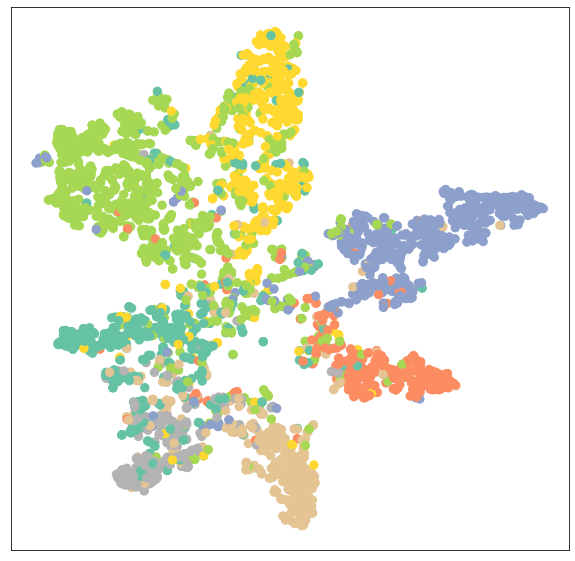

In [748]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## more complex GNN

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [749]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        # self.conv1 = GATConv(...)  # TODO
        # self.conv2 = GATConv(...)  # TODO
        # down:
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)  
        self.conv2 = GATConv(hidden_channels, hidden_channels) 
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = GAT(hidden_channels=16, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gnn2_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model


def gnn2_test(model,data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def gnn2_test2(model,data):
    model.eval()
    out = model(data.x, data.edge_index)

    #   true1 = 0
    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc
    print('acc1',acc1)


    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)
    print('acc2',true2/len(redunclass))

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc2 = true3/len(redunclass)
    print('acc3',true3/len(redunclass))
    return acc1,acc2,acc3

for epoch in range(1, 101):
    loss,model = gnn2_train(model,data)
    # val_acc = gnn2_test(data.val_mask)
    test_acc = gnn2_test(model,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')

print('\n')
acc1,acc2,acc3 = gnn_test2(model,data)

log['test'+str(index)]['gnn2'] = {}
log['test'+str(index)]['gnn2']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['gnn2']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['gnn2']['acc3']=f'{acc3:.4f}'


GAT(
  (conv1): GCNConv(1433, 16)
  (conv2): GATConv(16, 16, heads=1)
  (conv3): GCNConv(16, 7)
)
Epoch: 020, Loss: 1.7799, Test: 0.2393
Epoch: 040, Loss: 1.3300, Test: 0.5305
Epoch: 060, Loss: 0.8710, Test: 0.7475
Epoch: 080, Loss: 0.6226, Test: 0.7814
Epoch: 100, Loss: 0.4509, Test: 0.7954


acc1 0.7953795379537953
acc2 0.7943131462333826
acc3 0.7939438700147711


In [750]:
from torch_geometric.nn import GCNConv


class GCN_semi_light(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

model = GCN_semi_light(hidden_channels=16)
print(model)

GCN_semi_light(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [751]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN_semi_light(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gnn_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model

def gnn_test(model,data):
      model.eval()
      out = model(data.x, data.edge_index)
      
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def semi_gnn_test2(model,data):
    model.eval()
    out = model(data.x, data.edge_index)

    #   true1 = 0
    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc
    print('acc1',acc1)


    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)
    print('acc2',true2/len(redunclass))

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc3 = true3/len(redunclass)
    print('acc3',true3/len(redunclass))
    return acc1,acc2,acc3

# mlp_test2(model,data)

for epoch in range(1, 101):
    loss,model = gnn_train(model,data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9246
Epoch: 003, Loss: 1.9044
Epoch: 004, Loss: 1.8851
Epoch: 005, Loss: 1.8664
Epoch: 006, Loss: 1.8481
Epoch: 007, Loss: 1.8300
Epoch: 008, Loss: 1.8114
Epoch: 009, Loss: 1.7921
Epoch: 010, Loss: 1.7717
Epoch: 011, Loss: 1.7502
Epoch: 012, Loss: 1.7277
Epoch: 013, Loss: 1.7044
Epoch: 014, Loss: 1.6803
Epoch: 015, Loss: 1.6557
Epoch: 016, Loss: 1.6305
Epoch: 017, Loss: 1.6048
Epoch: 018, Loss: 1.5786
Epoch: 019, Loss: 1.5517
Epoch: 020, Loss: 1.5241
Epoch: 021, Loss: 1.4959
Epoch: 022, Loss: 1.4671
Epoch: 023, Loss: 1.4379
Epoch: 024, Loss: 1.4082
Epoch: 025, Loss: 1.3783
Epoch: 026, Loss: 1.3480
Epoch: 027, Loss: 1.3175
Epoch: 028, Loss: 1.2867
Epoch: 029, Loss: 1.2557
Epoch: 030, Loss: 1.2247
Epoch: 031, Loss: 1.1937
Epoch: 032, Loss: 1.1628
Epoch: 033, Loss: 1.1322
Epoch: 034, Loss: 1.1019
Epoch: 035, Loss: 1.0719
Epoch: 036, Loss: 1.0424
Epoch: 037, Loss: 1.0133
Epoch: 038, Loss: 0.9848
Epoch: 039, Loss: 0.9568
Epoch: 040, Loss: 0.9294


In [752]:
acc1,acc2,acc3 = semi_gnn_test2(model,data)

log['test'+str(index)]['semi gnn'] = {}
log['test'+str(index)]['semi gnn']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['semi gnn']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['semi gnn']['acc3']=f'{acc3:.4f}'

acc1 0.8003300330033003
acc2 0.7987444608567208
acc3 0.7976366322008862


#output untill now

In [755]:
log

{'dataset': Cora(),
 'raw data': 'Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])',
 'info': {'#of(edge_index,x,ei,train_mask': [10556, 2708, 2, 2708]},
 'test4': {'each_part_size': 10,
  'flag type 2': False,
  'mlp': {'acc1': '0.5347', 'acc2': '0.5798', 'acc3': '0.5798'},
  'gnn1': {'acc1': '0.7822', 'acc2': '0.7840', 'acc3': '0.7843'},
  'gnn2': {'acc1': '0.7797', 'acc2': '0.7795', 'acc3': '0.7781'},
  'semi gnn': {'acc1': '0.7797', 'acc2': '0.7866', 'acc3': '0.7858'}},
 'test5': {'each_part_size': 20,
  'flag type 2': False,
  'mlp': {'acc1': '0.5494', 'acc2': '0.5886', 'acc3': '0.5886'},
  'gnn1': {'acc1': '0.7872', 'acc2': '0.7925', 'acc3': '0.7925'},
  'gnn2': {'acc1': '0.7689', 'acc2': '0.7832', 'acc3': '0.7829'},
  'semi gnn': {'acc1': '0.8015', 'acc2': '0.8072', 'acc3': '0.8065'}},
 'test6': {'each_part_size': 50,
  'flag type 2': False,
  'mlp': {'acc1': '0.5666', 'acc2': '0.6004', 'acc3': '0.6004'},
  'gnn1': {'acc